# Train Plank Model
Using multiple videos of author and youtube experts performing planks, generate labels (IN/OUT Plank) for each frame of data (x,y,z coords for each of the 33 mediapipe pose landmarks + 4 critical angles)

In [1]:
# imports
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score 
import pickle

# import local utils
from utils import *

import seaborn as sns
sns.set()

In [2]:
# init mediapipe
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
# some useful functions
def find_angle(p1, p2, ref_pt = np.array([0,0])):
    p1_ref = p1 - ref_pt
    p2_ref = p2 - ref_pt

    cos_theta = (np.dot(p1_ref,p2_ref)) / (1.0 * np.linalg.norm(p1_ref) * np.linalg.norm(p2_ref))
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    # note degree will always be less than 180    
    degree = int(180 / np.pi) * theta

    return int(degree)

def get_landmark_array(pose_landmark, key, frame_width, frame_height):

    denorm_x = int(pose_landmark[key].x * frame_width)
    denorm_y = int(pose_landmark[key].y * frame_height)

    return np.array([denorm_x, denorm_y])

def get_landmark_features(kp_results, dict_features, feature, frame_width, frame_height):

    if feature == 'nose':
        return get_landmark_array(kp_results, dict_features[feature], frame_width, frame_height)

    elif feature == 'left' or 'right':
        shldr_coord = get_landmark_array(kp_results, dict_features[feature]['shoulder'], frame_width, frame_height)
        elbow_coord   = get_landmark_array(kp_results, dict_features[feature]['elbow'], frame_width, frame_height)
        wrist_coord   = get_landmark_array(kp_results, dict_features[feature]['wrist'], frame_width, frame_height)
        hip_coord   = get_landmark_array(kp_results, dict_features[feature]['hip'], frame_width, frame_height)
        knee_coord   = get_landmark_array(kp_results, dict_features[feature]['knee'], frame_width, frame_height)
        ankle_coord   = get_landmark_array(kp_results, dict_features[feature]['ankle'], frame_width, frame_height)
        foot_coord   = get_landmark_array(kp_results, dict_features[feature]['foot'], frame_width, frame_height)

        return shldr_coord, elbow_coord, wrist_coord, hip_coord, knee_coord, ankle_coord, foot_coord
    
    else:
       raise ValueError("feature needs to be either 'nose', 'left' or 'right")
    
def draw_dotted_line(frame, lm_coord, start, end, line_color):
    pix_step = 0

    for i in range(start, end+1, 8):
        cv2.circle(frame, (lm_coord[0], i+pix_step), 2, line_color, -1, lineType=cv2.LINE_AA)

    return frame

## global vars

In [4]:
left_features = {
    'shoulder': mp_pose.PoseLandmark.LEFT_SHOULDER.value,  # 11
    'elbow'   : mp_pose.PoseLandmark.LEFT_ELBOW.value,     # 13
    'wrist'   : mp_pose.PoseLandmark.LEFT_WRIST.value,     # 15                    
    'hip'     : mp_pose.PoseLandmark.LEFT_HIP.value,       # 23
    'knee'    : mp_pose.PoseLandmark.LEFT_KNEE.value,      # 25
    'ankle'   : mp_pose.PoseLandmark.LEFT_ANKLE.value,     # 27
    'foot'    : mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value # 31
}

right_features = {
    'shoulder': mp_pose.PoseLandmark.RIGHT_SHOULDER.value,  # 12
    'elbow'   : mp_pose.PoseLandmark.RIGHT_ELBOW.value,     # 14
    'wrist'   : mp_pose.PoseLandmark.RIGHT_WRIST.value,     # 16,
    'hip'     : mp_pose.PoseLandmark.RIGHT_HIP.value,       # 24,
    'knee'    : mp_pose.PoseLandmark.RIGHT_KNEE.value,      # 26,
    'ankle'   : mp_pose.PoseLandmark.RIGHT_ANKLE.value,     # 28,
    'foot'    : mp_pose.PoseLandmark.RIGHT_FOOT_INDEX.value # 32
}

dict_features = {}
dict_features['left'] = left_features
dict_features['right'] = right_features
dict_features['nose'] = 0

# font type
font = cv2.FONT_HERSHEY_SIMPLEX

# line type
linetype = cv2.LINE_AA

# set radius to draw arc
radius = 20

# Colors in RGB
COLORS = {
    'blue'       : (255, 127, 0), 
    'yellow'     : (0, 255, 255), 
    'white'      : (255,255,255),
    'light_blue' : (255, 204, 102)
}

## mediapipe processing functions

In [5]:
def process_frame(frame,pose,framenum=1):
    """
    Process a single video frame
    
    Returns keypoints, crit_angles_list
    """
    
    frame_height, frame_width, _ = frame.shape

    # Process the image.
    # recolor frame to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame.flags.writeable = False
    
    keypoints = pose.process(frame)

    # recolor back to BGR
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    # shoulder_vertical_angle, hip_vertical_angle, knee_vertical_angle, ankle
    crit_angles_list = [0,0,0,0]
    
    if keypoints.pose_landmarks:
        ps_lm = keypoints.pose_landmarks

        nose_coord = get_landmark_features(ps_lm.landmark, dict_features, 'nose', frame_width, frame_height)
        left_shldr_coord, left_elbow_coord, left_wrist_coord, left_hip_coord, left_knee_coord, left_ankle_coord, left_foot_coord = \
                            get_landmark_features(ps_lm.landmark, dict_features, 'left', frame_width, frame_height)
        
        right_shldr_coord, right_elbow_coord, right_wrist_coord, right_hip_coord, right_knee_coord, right_ankle_coord, right_foot_coord = \
                            get_landmark_features(ps_lm.landmark, dict_features, 'right', frame_width, frame_height)

        offset_angle = find_angle(left_shldr_coord, right_shldr_coord, nose_coord)   
        
        camera_view = 'right'        
        # determine camera view (left or right) - front will default to right for now
        if offset_angle > 35.0:
            # hard-coded for now - determined from squat code author, seems good
            camera_view = 'front'
            # print("camera view from front: "+str(framenum))

        # compute distance for both sides shoulder to foot    
        dist_l_sh_hip = abs(left_foot_coord[0] - left_shldr_coord[0])
        dist_r_sh_hip = abs(right_foot_coord[0] - right_shldr_coord)[0]        
        if dist_l_sh_hip > dist_r_sh_hip:
            camera_view = 'left'
            # print("camera view from left")
            
        
        # assign side specific coords
        if camera_view == 'left':
            shldr_coord = left_shldr_coord
            elbow_coord = left_elbow_coord
            wrist_coord = left_wrist_coord
            hip_coord = left_hip_coord
            knee_coord = left_knee_coord
            ankle_coord = left_ankle_coord
            foot_coord = left_foot_coord

            multiplier = -1
        
        elif camera_view == 'right':
            shldr_coord = right_shldr_coord
            elbow_coord = right_elbow_coord
            wrist_coord = right_wrist_coord
            hip_coord = right_hip_coord
            knee_coord = right_knee_coord
            ankle_coord = right_ankle_coord
            foot_coord = right_foot_coord

            multiplier = 1
        else:
            # just default to right
            shldr_coord = right_shldr_coord
            elbow_coord = right_elbow_coord
            wrist_coord = right_wrist_coord
            hip_coord = right_hip_coord
            knee_coord = right_knee_coord
            ankle_coord = right_ankle_coord
            foot_coord = right_foot_coord

            multiplier = 1

        
        # ------------------- Vertical Angle calculation --------------

        shoulder_vertical_angle = find_angle(hip_coord, np.array([shldr_coord[0], 0]), shldr_coord)
        hip_vertical_angle = find_angle(knee_coord, np.array([hip_coord[0], 0]), hip_coord)
        knee_vertical_angle = find_angle(ankle_coord, np.array([knee_coord[0], 0]), knee_coord)
        ankle_vertical_angle = find_angle(knee_coord, np.array([ankle_coord[0], 0]), ankle_coord)
        
        # ------------------------------------------------------------
        
        # save frame angles for later analyses
        crit_angles_list = [shoulder_vertical_angle, hip_vertical_angle, knee_vertical_angle, ankle_vertical_angle]
        
    
    return keypoints, crit_angles_list

In [6]:
def process_video(video_filename):
    with mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5,min_tracking_confidence=0.5,model_complexity=1,smooth_landmarks=True) as pose:
        # Create VideoCapture object
        cap = cv2.VideoCapture(video_filename)

        # Raise error if file cannot be opened
        if cap.isOpened() == False:
            print("Error opening video stream or file")
            raise TypeError

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        size = (frame_width, frame_height)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        # Get the number of frames in the video
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # create videowriter object to create new video with pose estimation overlayed
        # videowriter = cv2.VideoWriter(output_filename,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)

        # Create a NumPy array to store the pose data as before
        # The shape is lengthx33x3 - 3D XYZ data for 33 landmarks across 'length' number of frames
        data = np.empty((length, 33, 3))
        angles_data = np.empty((length, 4)) 
        frame_num = 0

        while cap.isOpened():
            # read current frame
            ret, frame = cap.read()
            if not ret:
                break
            
            # process current frame and get list of pose estimation results and list of critical angles
            results, angles_list = process_frame(frame,pose,frame_num)

            landmarks = results.pose_world_landmarks.landmark
            # landmarks = results.pose_landmarks.landmark # a normalized landmark list
            for i in range(len(mp_pose.PoseLandmark)):
                data[frame_num, i, :] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)

            for i in range(len(angles_list)):
                angles_data[frame_num,i] = angles_list[i]

            frame_num += 1

        cap.release()
        # videowriter.release()
        cv2.destroyAllWindows()
        print("The video was successfully processed")

    return data, angles_data

## make training dataset pipeline

In [8]:
training_dir = "../data/videos/training/"

In [ ]:
input_filename = training_dir+"joshplank-decent.mp4"
data, angles_data = process_video(input_filename)

In [25]:
feat_df = make_default_feature_matrix(data, angles_data)

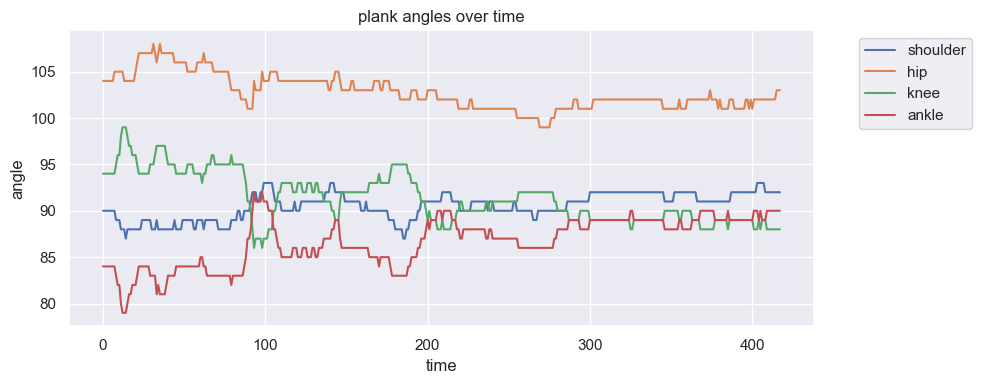

In [26]:
start = 300
# stop = 718
feat_df.loc[0:start,0] = 0
features_df = feat_df.copy()
plot_crit_angles(angles_data[start:])

In [21]:
features_df.shape

(718, 104)

The video was successfully processed


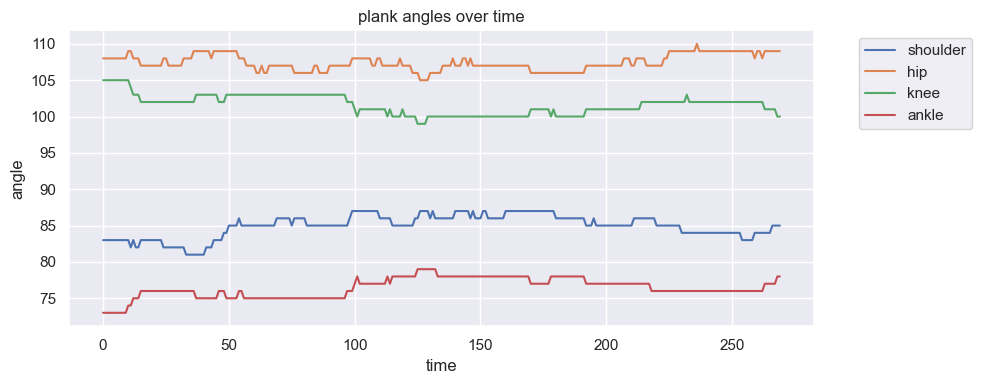

In [27]:
input_filename = training_dir+"joshplank-roundedback.mp4"
data, angles_data = process_video(input_filename)
feat_df = make_default_feature_matrix(data, angles_data)
start = 170
stop = 440
feat_df.loc[0:start,0] = 0
feat_df.loc[stop:,0] = 0
plot_crit_angles(angles_data[start:stop])

In [28]:
features_df = pd.concat([features_df,feat_df],ignore_index=True)

In [29]:
features_df.shape

(1218, 104)

The video was successfully processed


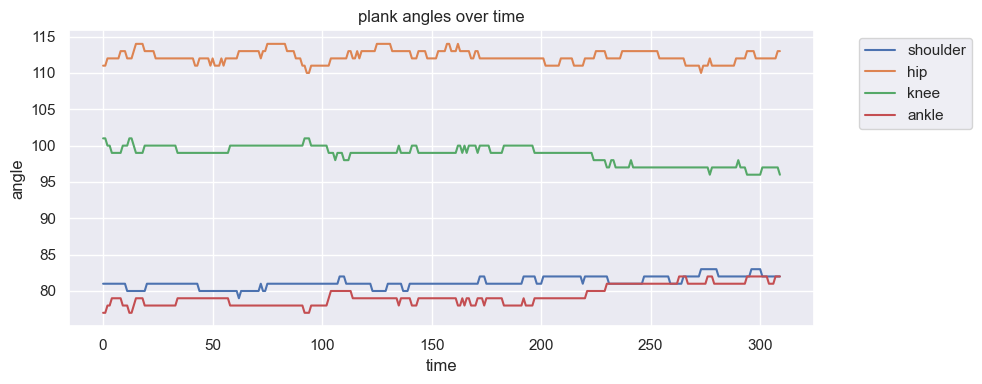

In [30]:
input_filename = training_dir+"joshplank-highhips.mp4"
data, angles_data = process_video(input_filename)
feat_df = make_default_feature_matrix(data, angles_data)
start = 200
stop = 510
feat_df.loc[0:start,0] = 0
feat_df.loc[stop:,0] = 0
plot_crit_angles(angles_data[start:stop])

In [31]:
features_df = pd.concat([features_df,feat_df],ignore_index=True)

In [32]:
features_df.shape

(1751, 104)

In [ ]:
input_filename = training_dir+"joshplank-test.mp4"
data, angles_data = process_video(input_filename)

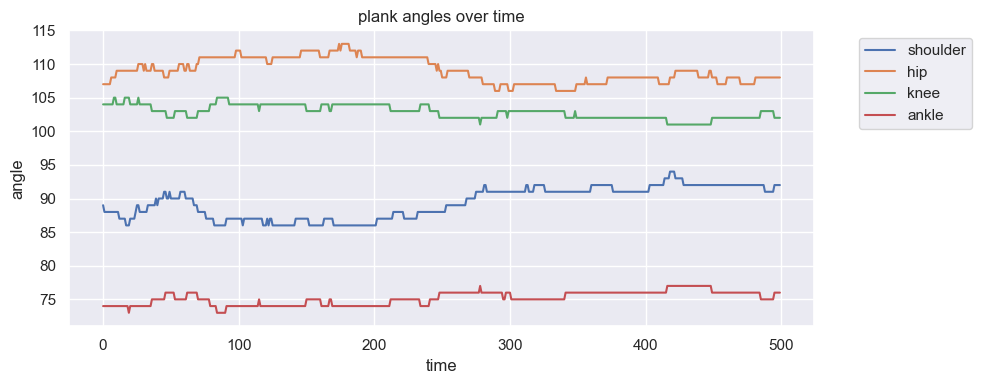

In [34]:
feat_df = make_default_feature_matrix(data, angles_data)
start = 300
stop = 800
feat_df.loc[0:start,0] = 0
feat_df.loc[stop:,0] = 0
plot_crit_angles(angles_data[start:stop])

In [35]:
features_df = pd.concat([features_df,feat_df],ignore_index=True)

In [36]:
features_df.shape

(2623, 104)

The video was successfully processed


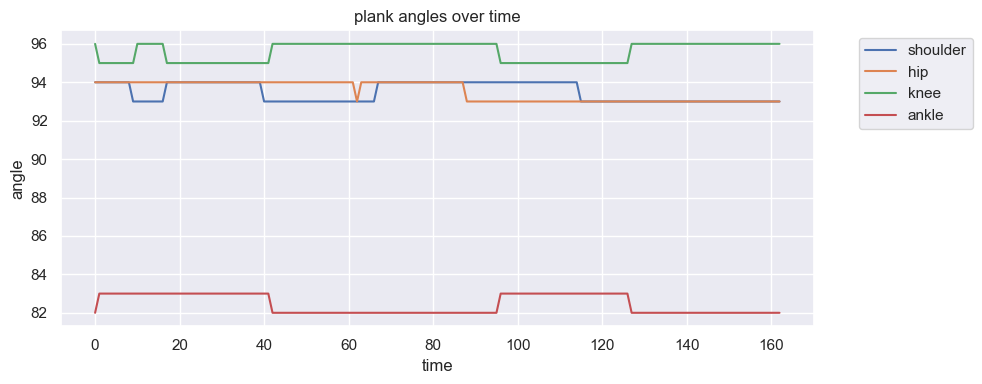

In [37]:
# the following from youtube should be all 1s predicted
input_filename = training_dir+"youtubeplank-goodform-movement.mp4"
data, angles_data = process_video(input_filename)
feat_df = make_default_feature_matrix(data, angles_data)
plot_crit_angles(angles_data)

In [38]:
features_df = pd.concat([features_df,feat_df],ignore_index=True)

In [39]:
features_df.shape

(2786, 104)

The video was successfully processed


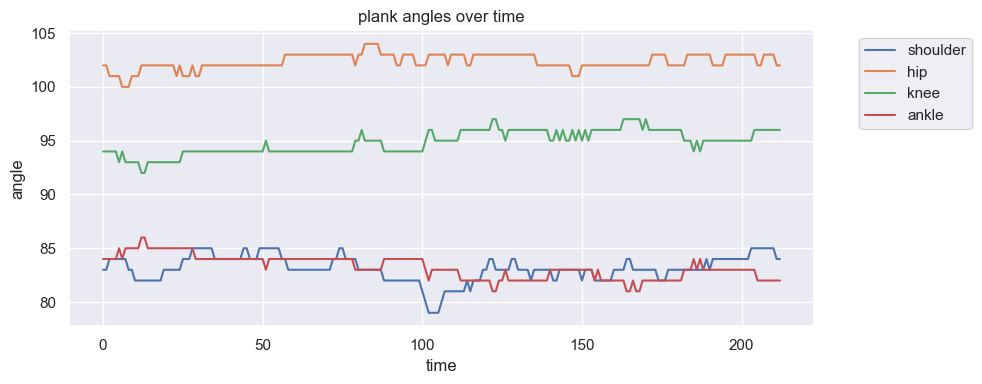

In [40]:
input_filename = training_dir+"youtubeplank-goodform-movement2.mp4"
data, angles_data = process_video(input_filename)
feat_df = make_default_feature_matrix(data, angles_data)
plot_crit_angles(angles_data)

In [41]:
features_df = pd.concat([features_df,feat_df],ignore_index=True)

In [42]:
features_df.shape

(2999, 104)

The video was successfully processed


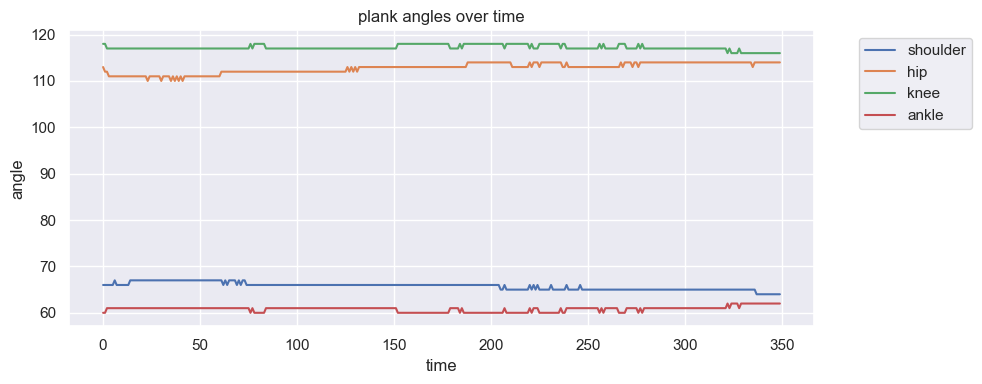

In [43]:
input_filename = training_dir+"youtubeplank-badform-movement.mp4"
data, angles_data = process_video(input_filename)
feat_df = make_default_feature_matrix(data, angles_data)
plot_crit_angles(angles_data)

In [44]:
features_df = pd.concat([features_df,feat_df],ignore_index=True)

In [45]:
features_df.shape

(3349, 104)

In [46]:
trainlabels = features_df[0].tolist()
trainlabels.count(0)/trainlabels.count(1)

0.5085585585585586

## train models on this collated/annotated data

In [50]:
X = features_df.drop(0,axis=1) # features
y = features_df[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [53]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000)),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'ada':make_pipeline(StandardScaler(), AdaBoostClassifier()),
    'nn':make_pipeline(StandardScaler(), MLPClassifier(alpha=1, max_iter=1000)),
}
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [54]:
# make predictions on test set
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

lr 0.9537313432835821
rc 0.9447761194029851
rf 0.9895522388059701
gb 0.9805970149253731
ada 0.9791044776119403
nn 0.9731343283582089


In [57]:
# save best model
with open('./plank_lr_trainedmodel.pkl', 'wb') as f:
    pickle.dump(fit_models['lr'], f)

## make test predictions with model

In [ ]:
# open saved model
with open('./plank_lr_trainedmodel.pkl', 'rb') as f:
    model = pickle.load(f)

In [32]:
testing_dir = "../data/videos/testing/"

The video was successfully processed


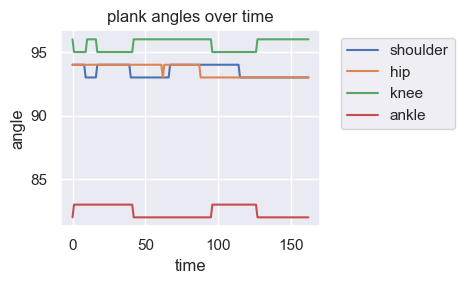

In [47]:
# input_filename = testing_dir+"joshplank-decent.mp4"
# input_filename = testing_dir+"IMG_2814.MOV"
input_filename = training_dir+"youtubeplank-goodform-movement.mp4"
data, angles_data = process_video(input_filename)
feat_df = make_default_feature_matrix(data, angles_data)
plot_crit_angles(angles_data)

In [39]:
start = 250
stop = 800
feat_df.loc[0:start,0] = 0
feat_df.loc[stop:,0] = 0

In [48]:
X_test = feat_df.drop(0,axis=1) # features
y_test = feat_df[0]

In [49]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

lr 1.0
rc 1.0
rf 1.0
gb 1.0
ada 1.0
nn 1.0


In [44]:
yhat = fit_models['rf'].predict(X_test)

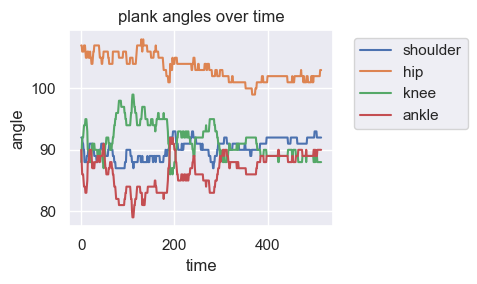

In [45]:
plot_crit_angles(angles_data[yhat == 1])

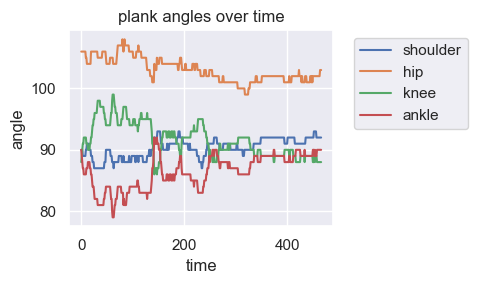

In [46]:
plot_crit_angles(angles_data[y_test == 1])